# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee

import non_parametric_ML_compsep as katame

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 2, 49152)
(15, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
1,50.0,33.46,23.66,58.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
3,68.0,16.87,11.93,47.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
5,89.0,11.30,7.99,41.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
7,119.0,4.58,3.24,33.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
9,166.0,5.57,3.94,28.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


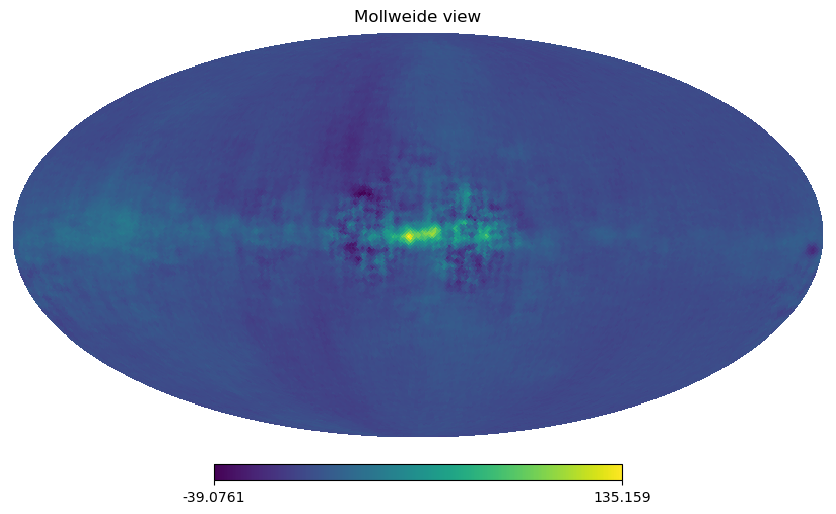

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = katame.get_noise_covar(depth_p, nside)
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [8]:
mixing_matrix_sampled

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 2.88437073e-03, 1.42538127e+00],
       [1.00000000e+00, 3.87988155e-03, 1.91733692e+00],
       [1.00000000e+00, 4.78088211e-03, 2.36258805e+00],
       [1.00000000e+00, 6.05138552e-03, 2.99043791e+00],
       [1.00000000e+00, 7.65722878e-03, 3.78400404e+00],
       [1.00000000e+00, 9.51435510e-03, 4.70174773e+00],
       [1.00000000e+00, 1.34402136e-02, 6.64180528e+00],
       [1.00000000e+00, 1.91378742e-02, 9.45744151e+00],
       [1.00000000e+00, 2.89375202e-02, 1.43001726e+01],
       [1.00000000e+00, 4.51218444e-02, 2.22980462e+01],
       [1.00000000e+00, 8.22050595e-02, 4.06236102e+01],
       [1.00000000e+00, 1.60639545e-01, 7.93839004e+01],
       [1.00000000e+00, 3.76180475e-01, 1.85898642e+02],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [9]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = katame.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 418 ms, sys: 161 ms, total: 579 ms
Wall time: 391 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [10]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [11]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  233 iterations !!
CPU times: user 30.8 s, sys: 14.4 s, total: 45.2 s
Wall time: 30 s


### Wiener filter part

In [12]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  250 iterations !!
CPU times: user 32.7 s, sys: 15.1 s, total: 47.8 s
Wall time: 31.6 s


In [13]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [14]:
%%time
c_ells_Wishart = katame.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)

red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = katame.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = katame.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)


CPU times: user 136 ms, sys: 58.1 ms, total: 194 ms
Wall time: 144 ms


## Sampling B_f : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [15]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [16]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

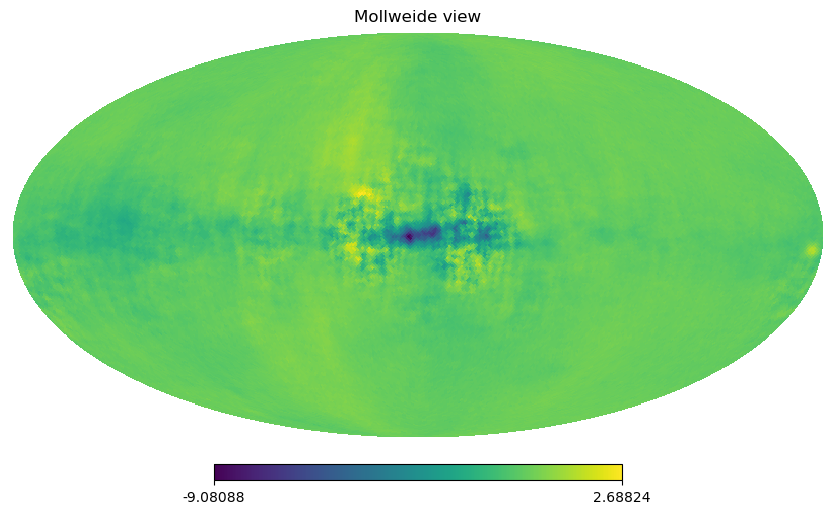

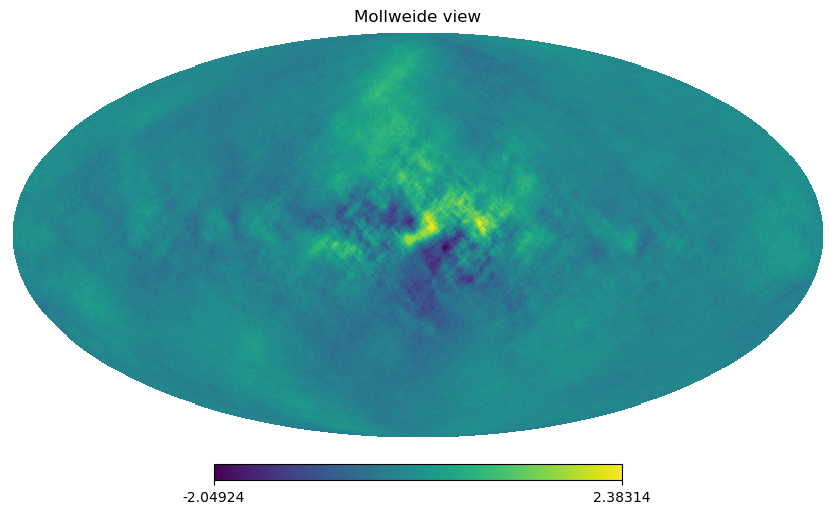

In [17]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [18]:
((1/np.sqrt(np.diag(freq_inverse_noise)))*hp.nside2resol(nside, arcmin=True))

array([37.42, 33.46, 21.31, 16.87, 12.07, 11.3 ,  6.56,  4.58,  4.79,
        5.57,  5.85, 10.79, 13.8 , 21.95, 47.45])

In [19]:
np.diag(freq_inverse_noise)

array([  2.15778848,   2.69876185,   6.65349042,  10.61661994,
        20.73967256,  23.66244125,  70.21158171, 144.04078501,
       131.6877595 ,  97.38813414,  88.28861488,  25.95216216,
        15.86566437,   6.27115285,   1.34197369])

In [20]:
np.diag(np.linalg.inv(np.diag((instrument['depth_p'] / hp.nside2resol(nside, arcmin=True))**2)))

array([  2.15778848,   2.69876185,   6.65349042,  10.61661994,
        20.73967256,  23.66244125,  70.21158171, 144.04078501,
       131.6877595 ,  97.38813414,  88.28861488,  25.95216216,
        15.86566437,   6.27115285,   1.34197369])

In [21]:
instrument['depth_p']

0     37.42
1     33.46
2     21.31
3     16.87
4     12.07
5     11.30
6      6.56
7      4.58
8      4.79
9      5.57
10     5.85
11    10.79
12    13.80
13    21.95
14    47.45
Name: depth_p, dtype: float64

In [22]:
full_data_without_CMB.shape

(15, 2, 49152)

In [23]:
freq_maps.shape

(15, 2, 49152)

In [24]:
print(cp_cp_noise)

[[ 2.27340244e-03 -2.26614996e-03 -4.44470378e-05]
 [-2.26614996e-03  7.47425105e-01 -1.46358961e-03]
 [-4.44470378e-05 -1.46358961e-03  6.17436610e-06]]


In [25]:
# for i in range(6):
#     hp.mollview(freq_maps[i,0])
#     hp.mollview(freq_maps[i,1])

In [26]:
# for i in range(6):
#     hp.mollview(full_data_without_CMB[i,0])
#     hp.mollview(full_data_without_CMB[i,1])

In [27]:
hp.nside2resol(nside)

0.015989479811663883

In [28]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = katame.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = katame.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))

[[0.00000000e+00 7.78422968e-03 2.58147548e-02 5.07568083e-02
  1.25503754e-01 1.81188726e-01 6.68017920e-01 1.93593892e+00
  2.52022378e+00 2.81817110e+00 3.98374514e+00 2.13339904e+00
  2.54865311e+00 2.35908526e+00 1.34197369e+00]
 [2.15778848e+00 3.84676459e+00 1.27569828e+01 2.50826994e+01
  6.20207030e+01 8.95387732e+01 3.30117145e+02 9.56690846e+02
  1.24542928e+03 1.39266713e+03 1.96866361e+03 1.05427052e+03
  1.25947832e+03 1.16579880e+03 0.00000000e+00]] (2, 15) (15, 2, 49152)
d-Bcsc -- mean 8.967278919218167 max 3458.431929813601 min -1966.1909207439842
B_fN^{-1} (d-Bcsc) - mean 33670.67332734177 max 3126672.4839685624 min -1763569.9144638982
B_fN^{-1} - mean 319.6406540935865 max 1968.6636141779366 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean 0.1855389250427437 max 0.7451661844880607 min -0.0015078948520506812


In [29]:
# hp.mollview(map_fgs[0,0])
# hp.mollview(map_fgs[0,1])
# hp.mollview(map_fgs[1,0])
# hp.mollview(map_fgs[1,1])

In [30]:
np.log(np.linalg.det(cp_cp_noise))

-19.383403941034025

In [31]:
%%time

# Calculation value log_proba with current value of B_f

regularization_constant = -1
regularization_factor = 10**10
# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))

CG-Python-0 WF finished in  24 iterations !!
Log_proba : 0.7046376852756797
<-> Proba : 2.0231135482897518
CPU times: user 3.33 s, sys: 1.12 s, total: 4.45 s
Wall time: 3.06 s


In [32]:
%%time
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()

full_initial_guess = np.random.randn(mixing_matrix_obj.params.ravel().shape[0]).reshape(mixing_matrix_obj.params.shape)
param_init = mixing_matrix_obj.params
mixing_matrix_obj.update_params(full_initial_guess)
# Calculation value log_proba with current value of B_f

print('Init values random :', full_initial_guess)
print('True initial values :', param_init)

regularization_constant = -1
regularization_factor = 10**10
# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))

mixing_matrix_obj.update_params(param_init)


Init values random : [[-0.06439827  0.16375233]
 [ 0.01522871  0.31831644]
 [ 0.83078426 -0.24903008]
 [-0.63800687  0.67399777]
 [ 0.30228917 -1.74783206]
 [-0.22757699 -1.12240531]
 [-0.46379769  2.81505786]
 [ 0.03312153 -0.03624895]
 [ 1.07564996  0.13850531]
 [ 1.12393614 -1.36583139]
 [ 1.21006608  0.68991248]
 [ 0.02758399  0.33289296]
 [ 0.16615433 -0.69180206]]
True initial values : [[2.88437073e-03 1.42538127e+00]
 [3.87988155e-03 1.91733692e+00]
 [4.78088211e-03 2.36258805e+00]
 [6.05138552e-03 2.99043791e+00]
 [7.65722878e-03 3.78400404e+00]
 [9.51435510e-03 4.70174773e+00]
 [1.34402136e-02 6.64180528e+00]
 [1.91378742e-02 9.45744151e+00]
 [2.89375202e-02 1.43001726e+01]
 [4.51218444e-02 2.22980462e+01]
 [8.22050595e-02 4.06236102e+01]
 [1.60639545e-01 7.93839004e+01]
 [3.76180475e-01 1.85898642e+02]]
CG-Python-0 WF finished in  24 iterations !!
Log_proba : -0.7516000883333087
<-> Proba : 0.4716113289044857
CPU times: user 3.34 s, sys: 1.24 s, total: 4.58 s
Wall time: 2.96 

In [33]:
mixing_matrix_obj.params.shape

(13, 2)

In [34]:
ver = '0a'
filename_backend_mcmc = "validation_step_4_LiteBIRD_{}ver{}.h5".format(nside,ver)
# ver = '0b'
# filename_backend_mcmc = "validation_step_4_ver{}.h5".format(ver)

In [35]:
# %%time
# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# number_steps_sampler = 300
# with_prints = False

# # whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)


# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.25,high=initial_guess_fg_mixing_matrix*.75, size=(n_walkers,dimensions_mixing_matrix))
# # print("Test", full_initial_guess)
# final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# CPU times: user 3h 37min 1s, sys: 1h 10min 14s, total: 4h 47min 15s
# Wall time: 44min 2s


In [36]:
%%time
# And now sampling B_f using emcee

n_walkers = 60
# We have 6*3 parameters to sample, trying to go with 100 steps first
number_steps_sampler = 120
with_prints = False

# whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

backend = emcee.backends.HDFBackend(filename_backend_mcmc)
backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(number_steps_sampler)

# This will be useful to testing convergence
old_tau = np.inf

# Initial guess
# full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.25,high=initial_guess_fg_mixing_matrix*.75, size=(n_walkers,dimensions_mixing_matrix))


# final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# Now we'll sample for up to number_steps_sampler steps
for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
    # Only check convergence every 100 steps
    if sample_params_mixing_matrix_FG.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau


100%|██████████| 120/120 [6:01:48<00:00, 180.90s/it] 

CPU times: user 7h 17s, sys: 3h 25min 3s, total: 10h 25min 20s
Wall time: 6h 4min 57s


In [64]:
autocorr.shape

(120,)

In [67]:
index = int(number_steps_sampler/100)

ValueError: x and y must have same first dimension, but have shapes (120,) and (1,)

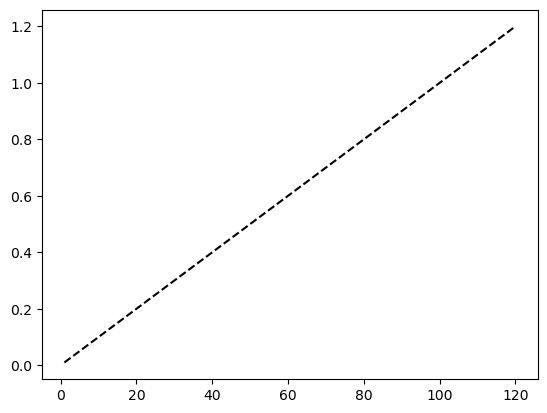

In [68]:
# time_array = 100 * np.arange(1, index + 1)
time_array = np.arange(1, number_steps_sampler+1)
plt.plot(time_array, time_array / 100.0, "--k")
plt.plot(time_array, autocorr[:index])
plt.xlim(0, time_array.max())
plt.ylim(0, autocorr[:index].max() + 0.1 * (autocorr.max() - autocorr.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [61]:
sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)

array([4.81710821, 4.96441818, 4.80342014, 4.37830796, 4.38276485,
       4.99757399, 4.72892389, 4.57421899, 4.38949561, 4.78505759,
       4.81232792, 4.11648244, 4.16024341, 4.76947161, 4.80634543,
       4.89259373, 4.87732035, 4.31048844, 4.71153261, 4.79059042,
       4.66766216, 4.92109877, 4.97126045, 5.0306655 , 4.77311824,
       4.83291478])

In [76]:
tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sample_params_mixing_matrix_FG.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sample_params_mixing_matrix_FG.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sample_params_mixing_matrix_FG.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


burn-in: 10
thin: 2
flat chain shape: (3300, 26)
flat log prob shape: (3300,)


AttributeError: 'NoneType' object has no attribute 'shape'

In [69]:
whole_chain_samples = sample_params_mixing_matrix_FG.get_chain()

In [70]:
print(whole_chain_samples.shape)

(120, 60, 26)


In [73]:
whole_chain_samples[-1].mean(axis=0)

array([-2.08310493e+12,  1.34404428e+16, -6.63706044e+12,  5.58601803e+15,
        3.46024985e+12, -2.58374271e+14,  3.47366245e+12,  1.92900142e+16,
       -1.05945021e+13,  1.27413607e+16,  1.24052877e+12, -9.14016527e+15,
       -6.10059493e+13,  1.99627826e+16,  1.30289031e+11,  3.34425147e+15,
       -1.65525011e+14,  1.67240080e+16,  1.52567530e+14, -3.42181358e+16,
        2.38288069e+14,  1.84007795e+17, -1.48540097e+14, -1.90665789e+16,
        1.52009200e+14,  1.32030773e+17])

In [74]:
np.abs(whole_chain_samples[-1]).min()

37575664217.424805

In [ ]:
autocorr_time = sample_params_mixing_matrix_FG.get_autocorr_time()

print(autocorr_time.shape)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [4.92166271 6.04822622 5.94470766 5.91877733 5.90582456 5.93614202
 5.83141322 5.92395121]

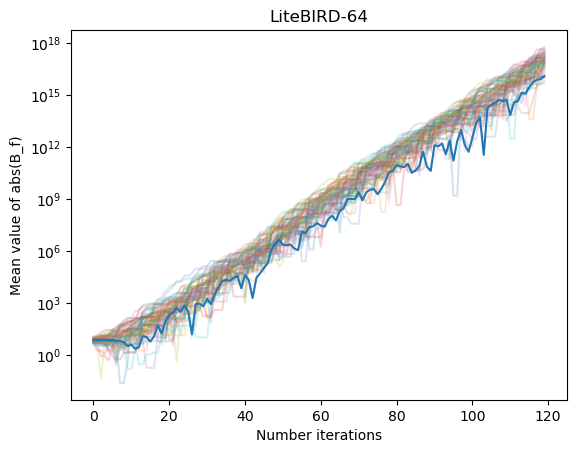

In [83]:
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(2))), alpha=.2)
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"LiteBIRD-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

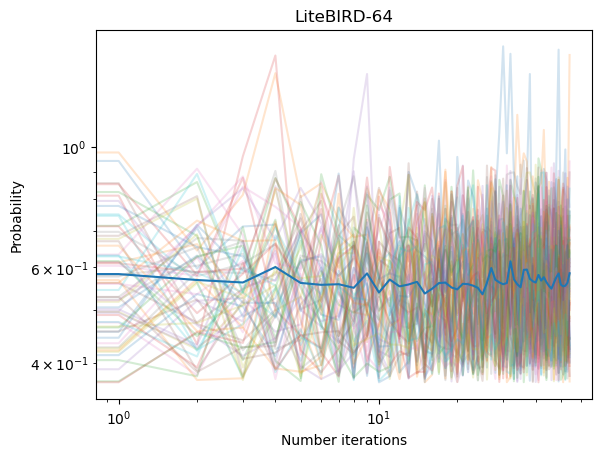

In [79]:
log_prob_samples_reshape = log_prob_samples.reshape((n_walkers, int((number_steps_sampler-burnin)/thin)))

plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape.T), alpha=.2)
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.mean(np.exp(log_prob_samples_reshape.T),axis=1))
plt.loglog()
plt.title(f"LiteBIRD-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Probability')
plt.show()

In [ ]:
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)